# Multiple ancilla qubit simulation for time dependent Fermi-Hubbard model

References:
- Zhiyan Ding, Chi-Fang Chen and Lin Lin:
  [Single-ancilla ground state preparation via Lindbladians](https://arxiv.org/abs/2308.15676)

- Zhiyan Ding and Xiantao Li and Lin Lin:
  [Simulating Open Quantum Systems Using Hamiltonian Simulations](https://arxiv.org/abs/2311.15533)

## TFIM damping model, time independent Hamiltonian

In [1]:
import matplotlib.pyplot as plt
import qsimulations as qs
import numpy as np
from qutip import *
import qib

import seaborn as sns

# Activate Seaborn's default styling
sns.set()
sns.set_palette("coolwarm") 



In [2]:
# Define custom creation/annihilation operators:

def JW_operator(op, poz, size):
    """ Jordan-Wiegner creation operator

    Args:
        op (np.array): type of operator defined as numpy array, i.e. X, Y, Z
        poz (int): position of the system the operator acts on, indexing starting from 0
        size (int): size of the total system

    Returns:
        np.array: numpy array of the operator
    """
    ret = 1
    if poz > size:
        return 0
    for i in np.arange(1, size + 1, 1):
        if i == poz:
            ret = np.kron(ret, op)
        else:
            ret = np.kron(ret, qs.Z)
    return ret



In [3]:
taylor_aprox_order = (
    8  # Taylor approximation used for simulating exp(-i*sqrt*(dt)*H_tilde)
)

g = 1  # Couppling coefficient
gamma = 0.1  # Damping parameter

T = 5  # Final time
dt = 0.01  # Time step
time_vec = np.arange(0, T, dt)  # Time vector to simulate on

systemSize = 2  # Size of the system
nrAncillas = 2  # Ancilla size
J = systemSize  # Nr of jump operators is equal to the number of lattice elements
systemSize_dim = np.power(2, systemSize)  # Hamiltonian system size
FermiHubbard_t = 1.0  # Kinetic hopping coefficient
FermiHubbard_u = 0.0  # Potential interaction strength
FermiHubbard_latt = qib.lattice.IntegerLattice((systemSize,), pbc=True)
field_hamil = qib.field.Field(qib.field.ParticleType.FERMION, FermiHubbard_latt)

T = 5  # Final time
dt = 0.01  # Time step
time_vec = np.arange(0, T, dt)  # Time vector to simulate on

# For spinful test:
# Layered lattice of 2x2x2
# latt_tmp = qib.lattice.IntegerLattice((systemSize, systemSize), pbc=False)
# field_hamil = qib.field.Field(qib.field.ParticleType.FERMION, qib.lattice.LayeredLattice(latt_tmp, systemSize)) 

# Fermi-Hubbard Hamiltonian
def H_operator(t=0):
    return Qobj(
        qib.operator.FermiHubbardHamiltonian(
            field_hamil, FermiHubbard_t, FermiHubbard_u, False # Try Spin full version, True
        )
        .as_matrix()
        .todense()
    )


def V_damping(i, t=0):
    if i == 0:
        sum = 0
        for j in np.arange(1, J + 1, 1):
            sum = sum + V_damping(j).full().conj().T @ V_damping(j).full()
        return Qobj(-1j * H_operator().full() - 0.5 * sum)

    if i >= 1 and i <= systemSize_dim:
        return Qobj(
            0.5
            * (
                JW_operator(qs.X, i, systemSize)
                + 1j * JW_operator(qs.Y, i, systemSize)
            )
        )
    return 0


def H_operator_derivative(t):
    return Qobj(0)


def V_operator_derivative(i, t):
    return Qobj(0)


QSystem = qs.qsimulations(systemSize, systemSize, nrAncillas)
QSystem.H_op = H_operator
QSystem.H_op_derivative = H_operator_derivative
QSystem.V_op = V_damping
QSystem.V_op_derivative = V_operator_derivative
QSystem._update_module_varibles()
QSystem._prep_energy_states()

rho_ground = QSystem.rho_ground
rho_highest_en = QSystem.rho_highest_en

Eigenvalues:  [-1.+0.j  0.+0.j  0.+0.j  1.+0.j] 


Eigenvectors:  [[ 0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [-0.70710678+0.j  0.70710678+0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j  1.        +0.j]
 [ 0.        +0.j  0.        +0.j  1.        +0.j  0.        +0.j]] 




### Exact simulation


/home/robi/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


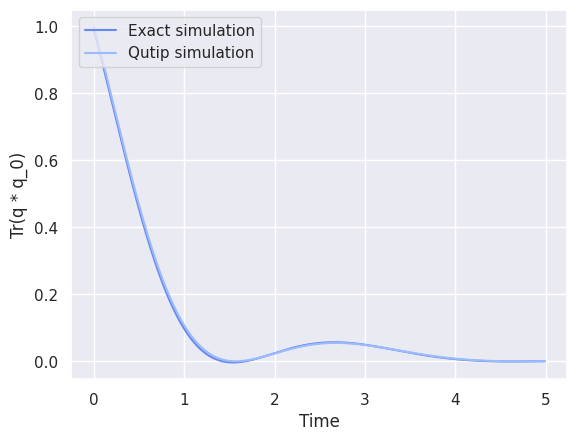

In [4]:
import matplotlib.pyplot as plt
from qutip import mesolve
import numpy as np

rho = QSystem.rho_highest_en
exact_trace_rho_highest_en = []
for t in time_vec:
    sum = 0
    for j in np.arange(1, J + 1, 1):
        sum = (
            sum
            + QSystem.V_op(j) @ rho @ QSystem.V_op(j).conj().trans()
            - 0.5
            * (
                QSystem.V_op(j).conj().trans() @ QSystem.V_op(j) @ rho
                + rho @ QSystem.V_op(j).conj().trans() @ QSystem.V_op(j)
            )
        )
    delta_rho = -1j * (QSystem.H_op() @ rho - rho @ QSystem.H_op()) + sum
    rho = rho + dt * delta_rho
    exact_trace_rho_highest_en.append((rho @ QSystem.rho_highest_en).tr())

V1 = V_damping(1)
V2 = V_damping(2)
results2 = mesolve(
    QSystem.H_op(),
    Qobj(QSystem.rho_highest_en),
    time_vec,
    [V1, V2],
    [QSystem.rho_highest_en],
)

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_0)")
plt.plot(time_vec, exact_trace_rho_highest_en, label="Exact simulation")
plt.plot(time_vec, results2.expect[0], label="Qutip simulation")
plt.legend(loc="upper left")

### First order approximation

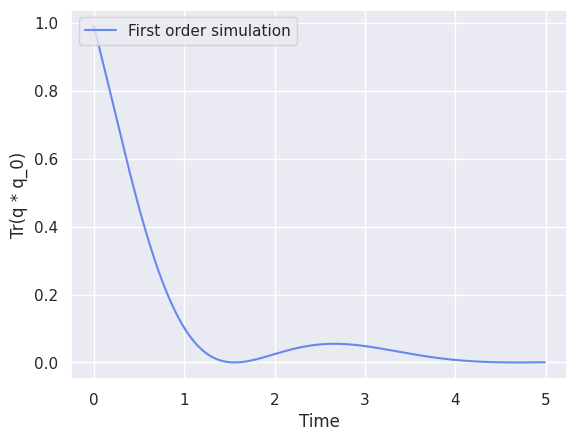

In [5]:
import math
import numpy as np

ancilla = 2  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = QSystem.rho_highest_en
first_order_trace_rho_highest_en = []
for t in time_vec:
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_first_order(dt),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    first_order_trace_rho_highest_en.append((rho @ QSystem.rho_highest_en).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_0)")
plt.plot(time_vec, first_order_trace_rho_highest_en, label="First order simulation")
plt.legend(loc="upper left")

### Second order approximation

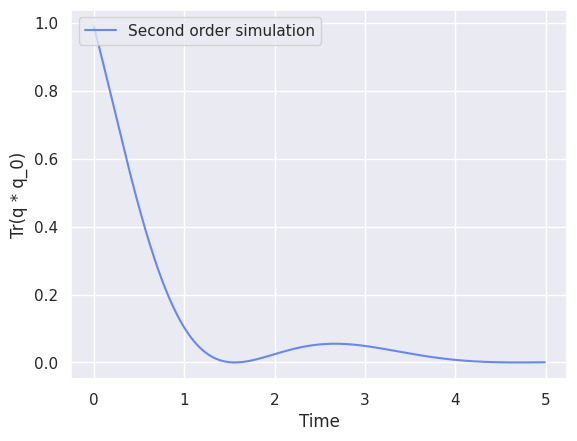

In [6]:
import math
import numpy as np

ancilla = 5  # Ancillary system size
QSystem.set_nr_of_ancillas(ancilla)
ancilla_dim = np.power(2, ancilla)
total_systemSize = systemSize + ancilla  # Total system size
total_systemSize_dim = np.power(2, total_systemSize)
taylor_aproximation_order = 10

# First order scheme
psi_ancilla = 1
for i in range(ancilla):
    psi_ancilla = np.kron(psi_ancilla, qs.ket_0)
rho_ancilla = Qobj(psi_ancilla.conj().T @ psi_ancilla)

rho = QSystem.rho_highest_en
second_order_trace_rho_highest_en = []
for t in time_vec:
    # print(t)
    # Extended system, zero initialized ancilla + hamiltonian system
    system = Qobj(
        tensor(rho_ancilla, rho),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )
    # First element of taylor approximation, I
    approximation = Qobj(
        qeye(ancilla_dim * systemSize_dim),
        dims=[[ancilla_dim, systemSize_dim], [ancilla_dim, systemSize_dim]],
    )

    approximation = qs.Taylor_approximtion(
        QSystem.H_tilde_second_order(dt),
        taylor_aproximation_order,
        np.sqrt(dt),
        approximation,
    )
    evolved_system = approximation @ system @ approximation.conj().trans()

    rho = evolved_system.ptrace(1)
    second_order_trace_rho_highest_en.append((rho @ QSystem.rho_highest_en).tr())

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_0)")
plt.plot(time_vec, second_order_trace_rho_highest_en, label="Second order simulation")
plt.legend(loc="upper left")

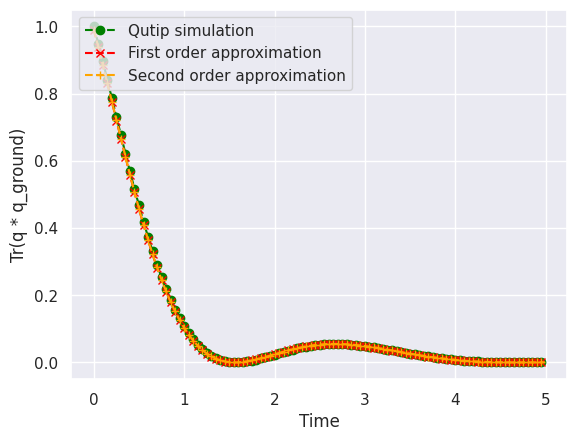

In [7]:
import matplotlib.pyplot as plt

total_nr_of_points = 100
plot_density = (int)(np.size(time_vec) / total_nr_of_points)

plt.figure()
plt.xlabel("Time")
plt.ylabel("Tr(q * q_ground)")

plt.plot(
    time_vec,
    results2.expect[0],
    label="Qutip simulation",
    color="green",
    marker="o",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    first_order_trace_rho_highest_en,
    label="First order approximation",
    color="red",
    marker="x",
    linestyle="dashed",
    markevery=plot_density,
)
plt.plot(
    time_vec,
    second_order_trace_rho_highest_en,
    label="Second order approximation",
    color="orange",
    marker="+",
    linestyle="dashed",
    markevery=plot_density,
)
plt.legend(loc="upper left")